In [52]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from matplotlib.gridspec import GridSpec
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, losses, metrics
from tensorflow.keras import optimizers
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
import keras.utils
from tensorflow.keras import utils as np_utils
import tensorflow as tf
from keras.layers import Dropout


# Allow for outputs from one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', 160)

import warnings
warnings.filterwarnings('ignore')

In [53]:
characteristics = pd.read_csv("caracteristiques-2019.csv")
characteristics.name = 'characteristics'
places = pd.read_csv("lieux-2019.csv")
places.name = 'places'
vehicles = pd.read_csv("Vehicules-2019.csv")
vehicles.name = 'vehicles'
drivers = pd.read_csv("usagers-2019.csv") #not sure why this one was erroring with 'r'
drivers.name = 'drivers'

In [54]:
datasets = [characteristics, places, vehicles, drivers]

characteristics = characteristics.set_index('Num_Acc')
places = places.set_index('Num_Acc')
vehicles = vehicles.set_index('id_vehicule')
drivers = drivers.set_index('id_vehicule')

for df in datasets:
    print (df.name,":",df.shape[0],"rows",df.shape[1],"columns")

characteristics : 58840 rows 15 columns
places : 58840 rows 18 columns
vehicles : 100710 rows 11 columns
drivers : 132977 rows 15 columns


In [55]:
vehicles = vehicles.drop('occutc',axis=1)
places = places.drop(['v2','lartpc','larrout'],axis=1)

In [56]:
characteristics = characteristics.drop(['an','adr','com'],axis=1)
characteristics = characteristics.drop('201900033874',axis=0)
#characteristics = characteristics[characteristics['dep']!='2B'] # comment / uncomment
#characteristics = characteristics[characteristics['dep']!='2A'] # comment / uncomment
#characteristics = characteristics[(characteristics['dep'].astype(float)<100)] # comment / uncomment
#places = places.loc[characteristics.index.values] # comment / uncomment
places = places.drop('201900033874',axis=0) # comment / uncomment
places = places.drop(['v1','vosp','pr','voie'],axis=1)
#characteristics = characteristics.drop('A01',axis=0) # comment / uncomment
vehicles = vehicles.drop('obs',axis=1)
drivers = drivers.drop(['secu3'],axis=1)

In [57]:
def encoder(df):
    label = LabelEncoder()
    for col in df.select_dtypes('object'):
        df[col] = df[col].astype('|S')
        df[col]=label.fit_transform(df[col])
    return df

In [58]:
df1 = pd.concat([characteristics, places.reindex(characteristics.index)], axis=1)
df2 = pd.concat([drivers, vehicles.reindex(drivers.index)], axis=1)

In [59]:
df1 = df1.loc[:,~df1.columns.duplicated()] # Get rid of duplicates
df2 = df2.loc[:,~df2.columns.duplicated()]
df2.reset_index(drop=True, inplace=True)
df2.index = df2['Num_Acc'].astype('str')
df2 = df2.drop(['Num_Acc'],axis=1)
df = pd.concat([df1.reindex(df2.index),df2],axis=1)
df = df.dropna()

In [60]:
df = df.reset_index()

In [61]:
df = df.head(25000)

In [62]:
df.shape

(25000, 40)

In [63]:
df = df.drop(['Num_Acc','mois','lat','long','hrmn','jour','pr1','etatp','actp','locp','trajet','situ','senc','catv','manv','motor'],axis=1)

In [64]:
#df_dum.head()

In [65]:
df_dum = pd.get_dummies(df,columns=['lum','dep','agg','int','atm','col','catr','circ','prof','plan','infra','num_veh','place','catu','sexe','secu1','secu2','obsm','choc'])

In [66]:
df_dum.shape

(25000, 248)

In [67]:
for col in df_dum.select_dtypes('float'):
    df_dum[col] = df_dum[col].astype(int)

In [68]:
X, y = df_dum.loc[:, df_dum.columns != 'grav'], df['grav']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [70]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [71]:
y_train.shape

(16750,)

In [72]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        #print(i, sequence)
        results[i, sequence] = 1.
    return results

In [73]:
X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

In [74]:
one_hot_train_labels = np_utils.to_categorical(y_train)
one_hot_test_labels = np_utils.to_categorical(y_test)

In [181]:
model = models.Sequential()
#model.add(Dropout(0.3))
model.add(layers.Dense(64, activation = 'relu',input_shape=(10000,)))
#model.add(Dropout(0.3))
model.add(layers.Dense(64, activation = 'relu'))
#model.add(Dropout(0.3))

model.add(layers.Dense(5, activation='sigmoid'))

In [182]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [183]:
x_val = X_train[:1000]
partial_x_train = X_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [184]:
X_train.shape

(16750, 10000)

In [185]:
x_val.shape

(1000, 10000)

In [186]:
y_val.shape

(1000, 5)

In [187]:
partial_x_train.shape

(15750, 10000)

In [188]:
partial_y_train.shape

(15750, 5)

In [189]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=32,
validation_data=(x_val, y_val))

Epoch 1/20
493/493 [==============================] - 4s 7ms/step - loss: 1.1033 - accuracy: 0.4283 - val_loss: 1.0626 - val_accuracy: 0.4130
Epoch 2/20
493/493 [==============================] - 3s 6ms/step - loss: 1.0706 - accuracy: 0.4493 - val_loss: 1.0475 - val_accuracy: 0.4690
Epoch 3/20
493/493 [==============================] - 3s 6ms/step - loss: 1.0655 - accuracy: 0.4526 - val_loss: 1.0533 - val_accuracy: 0.4560
Epoch 4/20
493/493 [==============================] - 3s 6ms/step - loss: 1.0616 - accuracy: 0.4643 - val_loss: 1.0601 - val_accuracy: 0.4540
Epoch 5/20
493/493 [==============================] - 3s 6ms/step - loss: 1.0597 - accuracy: 0.4610 - val_loss: 1.0492 - val_accuracy: 0.4540
Epoch 6/20
493/493 [==============================] - 3s 6ms/step - loss: 1.0569 - accuracy: 0.4679 - val_loss: 1.0423 - val_accuracy: 0.4760
Epoch 7/20
493/493 [==============================] - 3s 6ms/step - loss: 1.0552 - accuracy: 0.4685 - val_loss: 1.0487 - val_accuracy: 0.4600
Epoch 

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

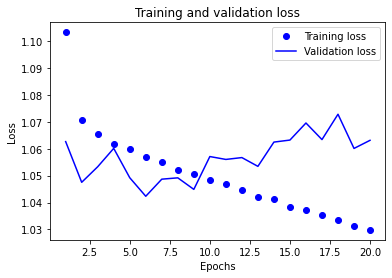

In [190]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

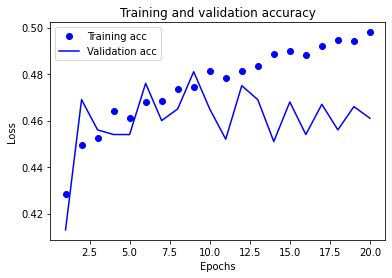

In [191]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [192]:
'''from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)'''

"from sklearn import svm\n\n#Create a svm Classifier\nclf = svm.SVC(kernel='linear') # Linear Kernel\n\n#Train the model using the training sets\nclf.fit(X_train, y_train)\n\n#Predict the response for test dataset\ny_pred = clf.predict(X_test)"

In [193]:
'''from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))'''

'from sklearn import metrics\n\n# Model Accuracy: how often is the classifier correct?\nprint("Accuracy:",metrics.accuracy_score(y_test, y_pred))'